In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
#from simsetup import get_sim
#from modelfitting import ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [15]:
dataset = pd.read_csv('../secondMMRintData/v1.0Initial.csv')

In [16]:
def hasnull(row):
    numnulls = row.isnull().sum()
    if numnulls == 0:
        return 0
    else:
        return 1

def tmax(row):
    #sim = get_sim(row, csvfolder)
    tmax = 1e4 # replace with a calculation of tmax
    return tmax

In [17]:
%%time
if 'hasnull' not in dataset.columns:
    dataset['hasnull'] = dataset.apply(hasnull, axis=1)
    #dataset['tmax'] = dataset.apply(tmax, axis=1)
    # dataset['tmax'] = dataset.apply(lambda x:1e4, axis=1) # this version would just set tmax=1e4 for all of them

    #dataset.to_csv(trainingdatafolder+"trainingdata.csv", encoding='ascii')

CPU times: user 6.09 s, sys: 51.8 ms, total: 6.14 s
Wall time: 6.14 s


In [18]:
dataset['EMavg'] = (dataset['EMcrossfar']+dataset['EMcrossnear']+dataset['EMcrossouter'])/3

In [19]:
dataset['Widavg']= (dataset['MMRstrengthWnear']+dataset['MMRstrengthWfar']+dataset['MMRstrengthWouter'])/3

In [20]:
dataset

,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRinWidnear,MMRstrengthWnear,twoMMRinWidnear,twoMMRstrengthWnear,Pratnear,EMcrossfar,...,EPfar,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg
0,0,0.221502,0.098431,9.878834e-03,False,0.013615,True,7.075038e-03,0.740735,0.300893,...,0.053981,0.007530,0.004649,True,False,1.235665e+07,8.315223e+07,0,0.370479,0.008936
1,1,0.190647,0.009185,1.703367e-03,True,0.002670,True,4.107756e-05,0.769720,0.403777,...,0.017682,0.082772,0.071393,True,False,1.348749e+05,2.133072e+05,0,0.421943,0.003806
2,2,0.125660,0.426660,1.310313e-01,False,0.033117,False,2.216802e-02,0.837345,0.720557,...,0.042240,0.054516,0.051803,True,False,1.276428e+04,9.321863e+03,0,0.594326,0.011694
3,3,0.216684,0.002876,1.857040e-07,True,0.000209,True,1.511511e-07,0.745134,0.235460,...,0.013245,0.057501,0.040897,True,True,1.000000e+09,1.000000e+09,0,0.318436,0.000596
4,4,0.024455,0.423830,1.145611e-01,False,0.003860,False,5.812017e-03,0.964408,0.034058,...,0.006777,0.011759,0.007401,True,False,8.791890e+01,8.791890e+01,0,0.039287,0.002078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,138538,0.082222,0.447117,2.475049e-02,False,0.007770,True,7.892905e-03,0.888238,0.664222,...,0.098020,0.132139,0.073446,True,False,6.990387e+05,8.267916e+05,0,0.515834,0.007007
138539,138539,0.251338,0.749336,1.701463e-03,False,0.002360,True,1.041106e-03,0.714399,0.272822,...,0.017757,0.043224,0.003523,True,False,3.075749e+08,6.576003e+08,0,0.372297,0.004651
138540,138540,0.131799,0.324267,2.940005e-02,False,0.017718,True,1.722615e-02,0.830517,0.366664,...,0.064086,0.047189,0.045870,True,False,1.193822e+07,3.363291e+07,0,0.348418,0.012790
138541,138541,0.209454,1.205802,5.207774e-02,False,0.033013,False,5.796469e-02,0.751843,0.395073,...,0.091233,0.217038,0.183490,True,False,2.064407e+08,4.316851e+07,0,0.430601,0.014493


In [21]:


twoBRwidth = ['MMRstrengthWnear','MMRstrengthWfar','MMRstrengthWouter','twoMMRstrengthWnear','twoMMRstrengthWfar','twoMMRstrengthWouter']
twoBRinW = ['MMRinWidnear','MMRinWidfar','MMRinWidouter','twoMMRinWidnear','twoMMRinWidfar','twoMMRinWidouter']

OGfeatures = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear','EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar','MEGNO', 'MEGNOstd']

MMRDATA = ['threeBRfillfac','MMRstrengthnear','MMRstrengthfar','MMRstrengthouter','twoMMRstrengthnear','twoMMRstrengthfar','twoMMRstrengthouter', 'EMcrossnear','EMcrossfar','EMcrossouter','eccMag','eccDir','pomegastd',
           'Pratnear','Pratfar','Pratouter']+twoBRwidth

TestFirst = ['threeBRfillfac', 'threeBRfillstd','MMRstrengthnear','MMRstrengthfar','MMRstrengthouter','MMRstrengthWnear','MMRstrengthWfar','MMRstrengthWouter']

testfew = ['MMRstrengthWnear','MMRstrengthWfar','MMRstrengthWouter', 'threeBRfillfac','EMcrossnear','EMcrossfar','EMcrossouter']

testavg = ['EMavg','Widavg','threeBRfillfac']

In [22]:
mask = (dataset['hasnull'] == 0 )
filtData = dataset[mask]

In [23]:
filtData

,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRinWidnear,MMRstrengthWnear,twoMMRinWidnear,twoMMRstrengthWnear,Pratnear,EMcrossfar,...,EPfar,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg
0,0,0.221502,0.098431,9.878834e-03,False,0.013615,True,7.075038e-03,0.740735,0.300893,...,0.053981,0.007530,0.004649,True,False,1.235665e+07,8.315223e+07,0,0.370479,0.008936
1,1,0.190647,0.009185,1.703367e-03,True,0.002670,True,4.107756e-05,0.769720,0.403777,...,0.017682,0.082772,0.071393,True,False,1.348749e+05,2.133072e+05,0,0.421943,0.003806
2,2,0.125660,0.426660,1.310313e-01,False,0.033117,False,2.216802e-02,0.837345,0.720557,...,0.042240,0.054516,0.051803,True,False,1.276428e+04,9.321863e+03,0,0.594326,0.011694
3,3,0.216684,0.002876,1.857040e-07,True,0.000209,True,1.511511e-07,0.745134,0.235460,...,0.013245,0.057501,0.040897,True,True,1.000000e+09,1.000000e+09,0,0.318436,0.000596
4,4,0.024455,0.423830,1.145611e-01,False,0.003860,False,5.812017e-03,0.964408,0.034058,...,0.006777,0.011759,0.007401,True,False,8.791890e+01,8.791890e+01,0,0.039287,0.002078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,138538,0.082222,0.447117,2.475049e-02,False,0.007770,True,7.892905e-03,0.888238,0.664222,...,0.098020,0.132139,0.073446,True,False,6.990387e+05,8.267916e+05,0,0.515834,0.007007
138539,138539,0.251338,0.749336,1.701463e-03,False,0.002360,True,1.041106e-03,0.714399,0.272822,...,0.017757,0.043224,0.003523,True,False,3.075749e+08,6.576003e+08,0,0.372297,0.004651
138540,138540,0.131799,0.324267,2.940005e-02,False,0.017718,True,1.722615e-02,0.830517,0.366664,...,0.064086,0.047189,0.045870,True,False,1.193822e+07,3.363291e+07,0,0.348418,0.012790
138541,138541,0.209454,1.205802,5.207774e-02,False,0.033013,False,5.796469e-02,0.751843,0.395073,...,0.091233,0.217038,0.183490,True,False,2.064407e+08,4.316851e+07,0,0.430601,0.014493


In [24]:
scrambled = filtData.sample(frac=1)

In [25]:
scrambled = scrambled.reset_index()

In [26]:
scrambled

,level_0,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRinWidnear,MMRstrengthWnear,twoMMRinWidnear,twoMMRstrengthWnear,Pratnear,...,EPfar,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg
0,99340,99340,0.072839,1.616048,0.015450,False,0.004299,False,0.004889,0.899909,...,0.048736,0.087955,0.015910,True,False,1.340223e+04,1.286193e+04,0,0.162607,0.002905
1,86753,86753,0.069736,0.132920,0.022295,False,0.000432,False,0.001171,0.903827,...,0.018953,0.015270,0.021260,True,False,5.235051e+04,1.341352e+05,0,0.119178,0.001447
2,77357,77357,0.250410,0.354365,0.010754,False,0.008944,True,0.006166,0.715196,...,0.017770,0.109614,0.028573,True,False,5.789494e+08,6.490863e+08,0,0.620291,0.012025
3,115836,115836,0.544638,0.074399,0.001195,True,0.019591,True,0.004375,0.520913,...,0.175251,0.256209,0.082123,True,False,1.680066e+07,3.358757e+06,0,0.859715,0.013609
4,88973,88973,0.108385,2.411275,0.023421,False,0.009205,False,0.012129,0.856968,...,0.013433,0.004286,0.007437,True,True,1.000000e+09,1.000000e+09,0,0.319778,0.003693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,79583,79583,0.099728,0.157886,0.040905,False,0.003046,True,0.007833,0.867115,...,0.004520,0.028976,0.014469,True,False,2.453709e+05,5.155383e+04,0,0.254699,0.001706
138539,86459,86459,0.052789,0.020830,0.012739,False,0.000271,True,0.001241,0.925739,...,0.008493,0.014195,0.013496,True,False,2.720636e+06,2.809440e+07,0,0.112711,0.000963
138540,43612,43612,0.081980,0.932120,0.027893,False,0.008948,True,0.009090,0.888529,...,0.004902,0.022979,0.009750,True,True,1.000000e+09,1.000000e+09,0,0.251423,0.005664
138541,89939,89939,0.093244,3.465850,0.034627,False,0.012987,True,0.013257,0.874845,...,0.015875,0.071549,0.014156,True,True,1.000000e+09,1.000000e+09,0,0.387722,0.006340


Now we do the train test split manually. We take 80\% of the rows for training, 20\% for testing (this is what we were doing before too)

In [27]:
#deciding training and not training, order is random
Nrows = int(0.8*scrambled.shape[0])
train = scrambled.iloc[:Nrows, :]
test = scrambled.iloc[Nrows:, :]
#test_tinst = tinst.iloc[Nrows:]


# dtrain = xgb.DMatrix(trainX, trainY)
# dtest = xgb.DMatrix(testX, testY)

In [28]:
#features var covers all features
resultBalance = train['Stable'].value_counts()[False]/train['Stable'].value_counts()[True]

In [29]:
realTest = test.loc[test['prelimStable']==True]

In [30]:
testT = realTest.loc[test['Stable'] == True]
testF = realTest.loc[test['Stable'] == False]


In [31]:
tT = pd.concat([testT, testF.sample(n=7300)])
tT = tT.sample(frac=1)

In [32]:
from sklearn.metrics import accuracy_score

In [33]:
train

,level_0,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRinWidnear,MMRstrengthWnear,twoMMRinWidnear,twoMMRstrengthWnear,Pratnear,...,EPfar,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg
0,99340,99340,0.072839,1.616048,0.015450,False,0.004299,False,0.004889,0.899909,...,0.048736,0.087955,0.015910,True,False,1.340223e+04,1.286193e+04,0,0.162607,0.002905
1,86753,86753,0.069736,0.132920,0.022295,False,0.000432,False,0.001171,0.903827,...,0.018953,0.015270,0.021260,True,False,5.235051e+04,1.341352e+05,0,0.119178,0.001447
2,77357,77357,0.250410,0.354365,0.010754,False,0.008944,True,0.006166,0.715196,...,0.017770,0.109614,0.028573,True,False,5.789494e+08,6.490863e+08,0,0.620291,0.012025
3,115836,115836,0.544638,0.074399,0.001195,True,0.019591,True,0.004375,0.520913,...,0.175251,0.256209,0.082123,True,False,1.680066e+07,3.358757e+06,0,0.859715,0.013609
4,88973,88973,0.108385,2.411275,0.023421,False,0.009205,False,0.012129,0.856968,...,0.013433,0.004286,0.007437,True,True,1.000000e+09,1.000000e+09,0,0.319778,0.003693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110829,117784,117784,0.089020,0.175956,0.043463,False,0.000908,True,0.005177,0.879929,...,0.024410,0.022730,0.025091,True,False,2.161166e+04,9.201072e+05,0,0.184091,0.002170
110830,138298,138298,0.303644,0.198827,0.009671,False,0.013376,True,0.013002,0.671836,...,0.096458,0.204735,0.059074,True,False,3.111868e+06,5.381264e+05,0,0.474639,0.006206
110831,93796,93796,0.261072,3.673627,0.123368,False,0.101236,False,0.034399,0.706139,...,0.034359,0.550859,0.035709,True,False,1.460212e+04,1.288164e+04,0,0.664096,0.052669
110832,58809,58809,0.087266,0.067378,0.020675,False,0.000925,True,0.003526,0.882063,...,0.017501,0.023852,0.006291,True,False,3.014502e+05,9.257886e+06,0,0.348910,0.001028


In [36]:
testModel = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 40, 
                         subsample = 0.95,
                         min_child_weight = 4,
                         n_estimators = 400,
                         scale_pos_weight=resultBalance)

In [37]:
testModel.fit(train[MMRDATA], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=40, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [39]:
resPred = testModel.predict_proba(tT[MMRDATA])[:,1]

print (metrics.roc_auc_score(tT['Stable'],resPred))
print(accuracy_score(testModel.predict(tT[MMRDATA]), tT["Stable"]))

0.9464754691931687
0.857594067563856


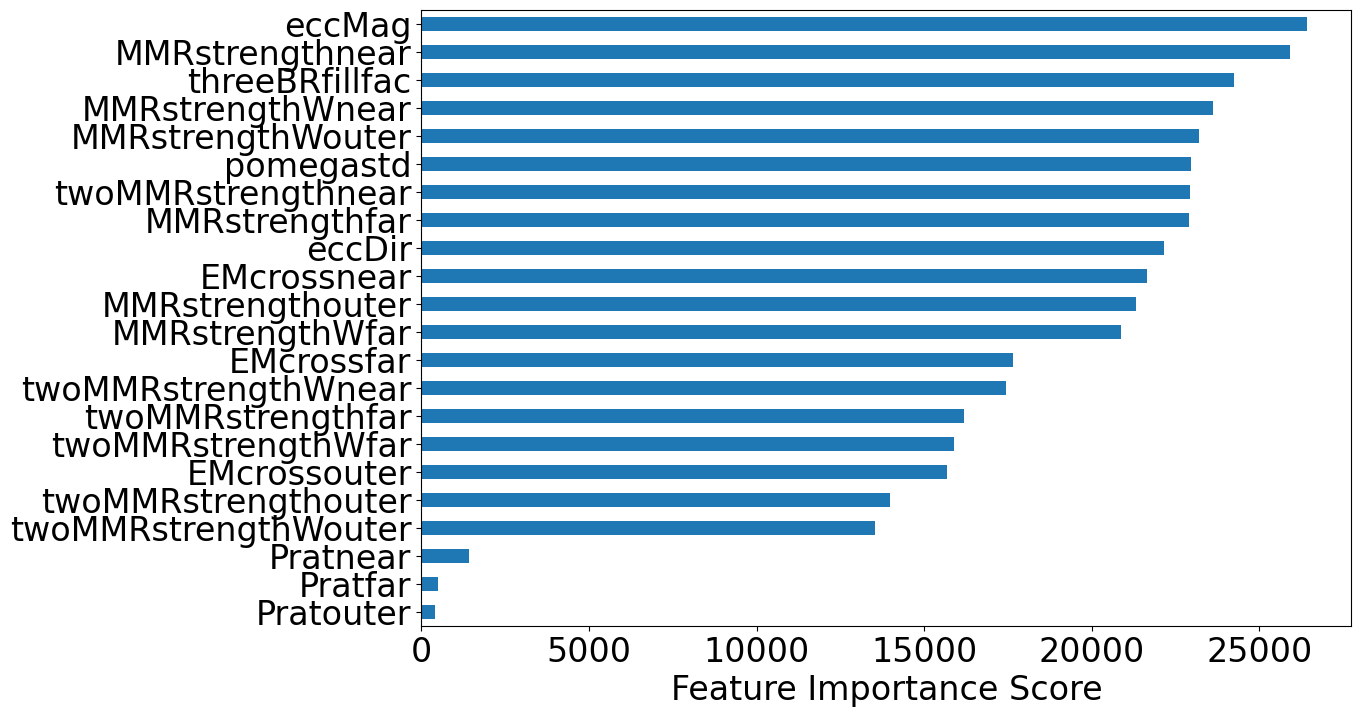

In [40]:
feat_imp = pd.Series(testModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

(0.0, 20.0)

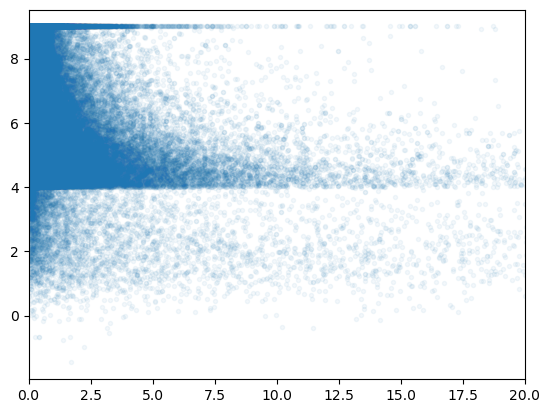

In [41]:
plt.plot(train['threeBRfillfac'],np.log10(train['instability_time']), '.', alpha = .05)
ax = plt.gca()
ax.set_xlim([0,20])


In [206]:
which = (filtData['MMRstrengthnear']+filtData['MMRstrengthfar']+filtData['MMRstrengthouter'])

In [207]:
filtData['avarage']=which

In [172]:
filtData['Wavarage']=(filtData['MMRstrengthWnear']+filtData['MMRstrengthWfar']+filtData['MMRstrengthWouter'])/3

In [67]:
np.median(filtData['avarage'])

0.14079908670065772

In [205]:
filtData = filtData.drop(['avarage'], axis=1)

In [153]:
filtData['PratRatio']=filtData['Pratnear']/filtData['Pratfar']

In [154]:
filtData

,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRinWidnear,MMRstrengthWnear,twoMMRinWidnear,twoMMRstrengthWnear,Pratnear,EMcrossfar,...,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg,avarage,PratRatio
0,0,0.221502,0.098431,9.878834e-03,False,0.013615,True,7.075038e-03,0.740735,0.300893,...,0.004649,True,False,1.235665e+07,8.315223e+07,0,0.370479,0.008936,0.210751,1.099069
1,1,0.190647,0.009185,1.703367e-03,True,0.002670,True,4.107756e-05,0.769720,0.403777,...,0.071393,True,False,1.348749e+05,2.133072e+05,0,0.421943,0.003806,0.086224,1.280193
2,2,0.125660,0.426660,1.310313e-01,False,0.033117,False,2.216802e-02,0.837345,0.720557,...,0.051803,True,False,1.276428e+04,9.321863e+03,0,0.594326,0.011694,0.142675,1.889766
3,3,0.216684,0.002876,1.857040e-07,True,0.000209,True,1.511511e-07,0.745134,0.235460,...,0.040897,True,True,1.000000e+09,1.000000e+09,0,0.318436,0.000596,0.010218,1.023238
4,4,0.024455,0.423830,1.145611e-01,False,0.003860,False,5.812017e-03,0.964408,0.034058,...,0.007401,True,False,8.791890e+01,8.791890e+01,0,0.039287,0.002078,0.203940,1.014094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,138538,0.082222,0.447117,2.475049e-02,False,0.007770,True,7.892905e-03,0.888238,0.664222,...,0.073446,True,False,6.990387e+05,8.267916e+05,0,0.515834,0.007007,0.152555,1.906979
138539,138539,0.251338,0.749336,1.701463e-03,False,0.002360,True,1.041106e-03,0.714399,0.272822,...,0.003523,True,False,3.075749e+08,6.576003e+08,0,0.372297,0.004651,0.308484,1.025866
138540,138540,0.131799,0.324267,2.940005e-02,False,0.017718,True,1.722615e-02,0.830517,0.366664,...,0.045870,True,False,1.193822e+07,3.363291e+07,0,0.348418,0.012790,0.152257,1.326907
138541,138541,0.209454,1.205802,5.207774e-02,False,0.033013,False,5.796469e-02,0.751843,0.395073,...,0.183490,True,False,2.064407e+08,4.316851e+07,0,0.430601,0.014493,0.412438,1.238861


In [216]:
plot = filtData.drop(filtData[filtData['threeBRfillfac'] >15].index)
plot = plot.drop(plot[plot['avarage'] >1000].index)


/tmp/ipykernel_35889/612081979.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter((plot['threeBRfillfac']**.5),np.log10(plot['instability_time']), s=1, c=((plot['threeBRfillfac'])), cmap=plt.cm.get_cmap("copper",25),alpha=.5)


(4.0, 9.0)

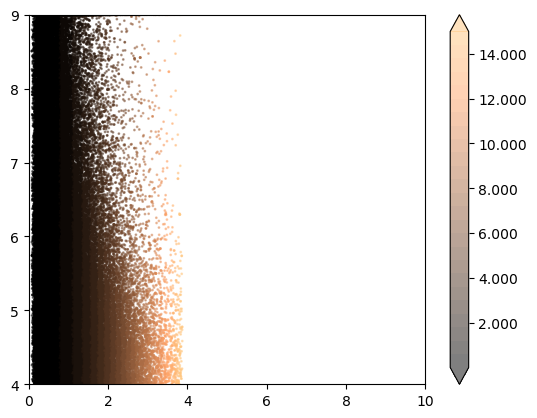

In [240]:
ax = plt.axes()
plt.scatter((plot['threeBRfillfac']**.5),np.log10(plot['instability_time']), s=1, c=((plot['threeBRfillfac'])), cmap=plt.cm.get_cmap("copper",25),alpha=.5)
cbar = plt.colorbar(orientation="vertical", extend="both",
                   pad=0.05, shrink=1, aspect=20, format="%.3f")
ax.set_xlim([0,10])
ax.set_ylim([4,9])

In [237]:
tester = filtData.drop(filtData[filtData['threeBRfillfac']**.5 >.5].index)
tester = tester.drop(tester[tester['threeBRfillfac']**.5 <.4].index)

In [239]:
tester[MMRDATA].describe()

,threeBRfillfac,MMRstrengthnear,MMRstrengthfar,MMRstrengthouter,twoMMRstrengthnear,twoMMRstrengthfar,twoMMRstrengthouter,EMcrossnear,EMcrossfar,EMcrossouter,...,pomegastd,Pratnear,Pratfar,Pratouter,MMRstrengthWnear,MMRstrengthWfar,MMRstrengthWouter,twoMMRstrengthWnear,twoMMRstrengthWfar,twoMMRstrengthWouter
count,13927.000000,1.392700e+04,1.392700e+04,1.392700e+04,13927.000000,13927.000000,13927.000000,13927.000000,13927.000000,13927.000000,...,13927.000000,13927.000000,13927.000000,13927.000000,13927.000000,1.392700e+04,1.392700e+04,13927.000000,13927.000000,13927.000000
mean,0.202610,4.233078e+00,1.241559e+00,9.963643e-01,0.021156,0.004420,0.000745,0.181675,0.406822,0.670079,...,1.843693,0.787429,0.619091,0.492020,0.007749,6.533195e-03,4.115639e-03,0.007149,0.002855,0.001008
std,0.026005,1.547172e+02,2.294072e+01,2.305143e+01,0.140790,0.008372,0.001852,0.096616,0.191927,0.314896,...,0.978380,0.087719,0.117887,0.125914,0.025242,8.984475e-03,6.598023e-03,0.025501,0.006315,0.003313
min,0.160000,6.213388e-07,2.448343e-10,2.140631e-12,0.000000,0.000000,0.000000,0.034824,0.079328,0.151738,...,0.006911,0.459053,0.321607,0.153010,0.000001,8.072375e-10,9.711670e-12,0.000000,0.000000,0.000000
25%,0.179714,5.598301e-02,6.365362e-03,8.550696e-04,0.004081,0.000113,0.000000,0.109276,0.251655,0.419834,...,1.048404,0.733745,0.525248,0.392159,0.001625,1.072493e-03,4.267598e-04,0.001506,0.000095,0.000000
50%,0.201319,2.025657e-01,2.691533e-02,5.594538e-03,0.010518,0.001205,0.000082,0.160386,0.377835,0.606251,...,1.799463,0.800015,0.618319,0.491237,0.004288,3.174293e-03,1.630618e-03,0.003748,0.000814,0.000109
75%,0.224918,7.938197e-01,1.159061e-01,2.360874e-02,0.023494,0.004803,0.000646,0.229242,0.536136,0.866523,...,2.597157,0.855945,0.714130,0.591077,0.010135,8.326221e-03,5.036837e-03,0.008436,0.002888,0.000747
max,0.249990,1.470546e+04,2.310013e+03,1.442032e+03,10.994015,0.125842,0.046468,0.680496,1.130412,2.495809,...,4.992489,0.949949,0.891805,0.809039,1.874854,1.454567e-01,1.110686e-01,1.876480,0.146942,0.149582


(0.0, 30.0)

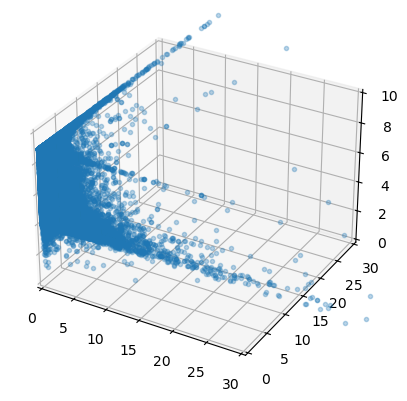

In [53]:
ax = plt.axes(projection='3d')
ax.plot3D(train['threeBRfillfac'], train['MMRstrengthnear'],np.log10(train['instability_time']),'.', alpha = 0.3)
ax.set_xlim([0,30])
ax.set_zlim([0,10])
ax.set_ylim([0,30])

In [120]:
test['spockres'] = testModel.predict(test[MMRDATA])

/tmp/ipykernel_23824/1980874473.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['spockres'] = testModel.predict(test[MMRDATA])


In [36]:
regtest = test.drop(test[test['instability_time'] >=1e9].index)


In [121]:
test

,level_0,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRinWidnear,MMRstrengthWnear,twoMMRinWidnear,twoMMRstrengthWnear,EMcrossfar,...,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg,spockres
110834,28623,28623,0.371990,0.019563,0.006857,True,0.002472,True,0.003948,0.516123,...,0.059041,0.035316,True,False,2.689905e+06,1.388138e+07,0,0.656073,0.003111,1
110835,69249,69249,0.070013,0.121733,0.075546,False,0.002631,False,0.007652,0.169723,...,0.012004,0.011525,True,False,2.285046e+06,9.885070e+05,0,0.163785,0.002628,0
110836,126953,126953,0.134456,0.104013,0.009641,False,0.000125,True,0.001074,0.399606,...,0.060579,0.063726,True,False,1.199777e+05,2.158910e+05,0,0.373951,0.003074,0
110837,122796,122796,0.151126,0.088109,0.084463,False,0.001135,False,0.013893,0.391030,...,0.062948,0.014957,True,False,1.782515e+05,1.000000e+09,0,0.381136,0.002783,0
110838,113465,113465,0.069015,1.181315,0.013833,False,0.001337,True,0.001909,0.077526,...,0.018324,0.008897,True,False,8.174826e+05,1.343023e+05,0,0.099477,0.001439,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,73201,73201,0.093779,1.010805,0.053300,False,0.019280,True,0.019682,0.311751,...,0.069285,0.008306,True,False,4.433063e+04,4.833132e+04,0,0.280098,0.012790,0
138539,96619,96619,0.211884,0.633114,0.000953,False,0.004110,True,0.000853,0.212120,...,0.148656,0.133666,True,False,1.177032e+05,9.628703e+04,0,0.297651,0.005434,0
138540,111485,111485,0.118282,0.335324,0.056656,False,0.007004,True,0.013420,0.209238,...,0.220995,0.130572,True,False,1.794668e+05,9.150920e+04,0,0.226596,0.012801,0
138541,110503,110503,0.099747,0.086785,0.024360,False,0.001571,True,0.004681,0.183172,...,0.015892,0.019474,True,False,9.634037e+04,7.603762e+04,0,0.194704,0.002754,0


In [123]:
test['spockright'] = test['Stable']==test['spockres']

/tmp/ipykernel_23824/1426527784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['spockright'] = test['Stable']==test['spockres']


In [124]:
test

,level_0,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRinWidnear,MMRstrengthWnear,twoMMRinWidnear,twoMMRstrengthWnear,EMcrossfar,...,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg,spockres,spockright
110834,28623,28623,0.371990,0.019563,0.006857,True,0.002472,True,0.003948,0.516123,...,0.035316,True,False,2.689905e+06,1.388138e+07,0,0.656073,0.003111,1,False
110835,69249,69249,0.070013,0.121733,0.075546,False,0.002631,False,0.007652,0.169723,...,0.011525,True,False,2.285046e+06,9.885070e+05,0,0.163785,0.002628,0,True
110836,126953,126953,0.134456,0.104013,0.009641,False,0.000125,True,0.001074,0.399606,...,0.063726,True,False,1.199777e+05,2.158910e+05,0,0.373951,0.003074,0,True
110837,122796,122796,0.151126,0.088109,0.084463,False,0.001135,False,0.013893,0.391030,...,0.014957,True,False,1.782515e+05,1.000000e+09,0,0.381136,0.002783,0,True
110838,113465,113465,0.069015,1.181315,0.013833,False,0.001337,True,0.001909,0.077526,...,0.008897,True,False,8.174826e+05,1.343023e+05,0,0.099477,0.001439,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,73201,73201,0.093779,1.010805,0.053300,False,0.019280,True,0.019682,0.311751,...,0.008306,True,False,4.433063e+04,4.833132e+04,0,0.280098,0.012790,0,True
138539,96619,96619,0.211884,0.633114,0.000953,False,0.004110,True,0.000853,0.212120,...,0.133666,True,False,1.177032e+05,9.628703e+04,0,0.297651,0.005434,0,True
138540,111485,111485,0.118282,0.335324,0.056656,False,0.007004,True,0.013420,0.209238,...,0.130572,True,False,1.794668e+05,9.150920e+04,0,0.226596,0.012801,0,True
138541,110503,110503,0.099747,0.086785,0.024360,False,0.001571,True,0.004681,0.183172,...,0.019474,True,False,9.634037e+04,7.603762e+04,0,0.194704,0.002754,0,True


In [127]:
tR = test.drop(test[test['spockright'] ==False].index)

In [128]:
tW = test.drop(test[test['spockright'] ==True].index)

In [144]:
plot = tR.drop(tR[tR['EMavg']>.5 ].index)

/tmp/ipykernel_23824/905772591.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(plot['threeBRfillfac'],np.log10(plot['instability_time']), s=1, c=((plot['EMavg'])), cmap=plt.cm.get_cmap("coolwarm",25),alpha=0.7)


(4.0, 9.0)

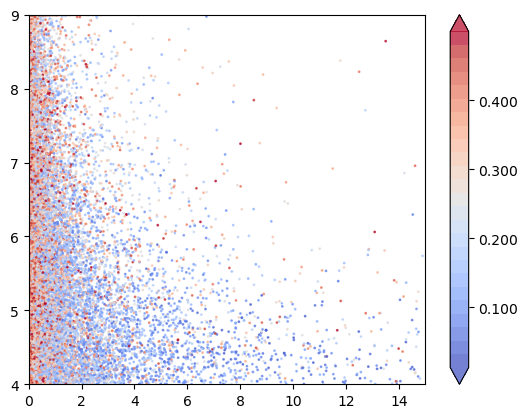

In [149]:
ax = plt.axes()
plt.scatter(plot['threeBRfillfac'],np.log10(plot['instability_time']), s=1, c=((plot['EMavg'])), cmap=plt.cm.get_cmap("coolwarm",25),alpha=0.7)
cbar = plt.colorbar(orientation="vertical", extend="both",
                   pad=0.05, shrink=1, aspect=20, format="%.3f")
ax.set_xlim([0,15])
ax.set_ylim([4,9])